In [2]:
import os
import sys
import glob

sys.path.append("Hand_pose_estimation_3D/arm_and_hand")
sys.path.append("Hand_pose_estimation_3D")

from dataloader_ann import HandArmLandmarksDataset_ANN

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime

import open3d as o3d
from utilities import convert_to_left_shoulder_coord
import time

from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from csv_writer import fusion_csv_columns_name
import matplotlib.pyplot as plt

import joblib
import sklearn

import json
from utilities import (convert_to_left_shoulder_coord,
    convert_to_wrist_coord,
    flatten_two_camera_input)
from left_arm_angle_calculator import LeftArmAngleCalculator

In [3]:
arm_hand_fused_names = ["left shoulder", "left elbow", "left hip", "right shoulder", "right hip", 
 "WRIST", "THUMB_CMC", "THUMB_MCP", "THUMB_IP", "THUMB_TIP", "INDEX_FINGER_MCP", 
 "INDEX_FINGER_PIP", "INDEX_FINGER_DIP", "INDEX_FINGER_TIP", "MIDDLE_FINGER_MCP", 
 "MIDDLE_FINGER_PIP", "MIDDLE_FINGER_DIP", "MIDDLE_FINGER_TIP", "RING_FINGER_MCP", 
 "RING_FINGER_PIP", "RING_FINGER_DIP", "RING_FINGER_TIP", "PINKY_MCP", "PINKY_PIP", 
 "PINKY_DIP", "PINKY_TIP", "right elbow"]

In [4]:
measure_noise_csv_files = [
    "data/2024-09-30/2024-09-30-17:09/landmarks_all_2024-09-30-17:09.csv",
    "data/2024-09-30/2024-09-30-17:23/landmarks_all_2024-09-30-17:23.csv",
    "data/2024-09-30/2024-09-30-17:25/landmarks_all_2024-09-30-17:25.csv",
    "data/2024-09-30/2024-09-30-17:26/landmarks_all_2024-09-30-17:26.csv",
    "data/2024-09-30/2024-09-30-17:27/landmarks_all_2024-09-30-17:27.csv",
    "data/2024-09-30/2024-09-30-17:28/landmarks_all_2024-09-30-17:28.csv"
]

Get the noise when the left arm does not move

In [8]:
angles_std = []
left_arm_angle_calculator = LeftArmAngleCalculator(3, arm_hand_fused_names)

for csv_file in measure_noise_csv_files:
    data = pd.read_csv(csv_file)
    total_rows = len(data)

    start_idx = total_rows // 4  
    end_idx = start_idx + total_rows // 2  

    middle_data = data.iloc[start_idx:end_idx]
    gt_data = middle_data.loc[:, "left_shoulder_output_x":"right_pinky_tip_output_z"].values
    gt_data = gt_data.reshape(-1, 3, 48)
    gt_data = np.transpose(gt_data, (0, 2, 1))

    angles_through_frame = []
    for i in range(gt_data.shape[0]):
        arm_hand_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
            gt_data[i],
            arm_hand_fused_names)

        result = left_arm_angle_calculator(arm_hand_XYZ_wrt_shoulder,
            xyz_origin)
        angles = result["left_arm"]["angles"]
        angles = np.array(angles)
        angles_through_frame.append(angles)

    angles_through_frame = np.array(angles_through_frame)
    angles_std.append(np.var(angles_through_frame, axis=0))
    
#angles_error = np.array(angles_error)
#lmks_error = lmks_error.reshape(-1, 3, 48)
#lmks_error = np.transpose(lmks_error, (0, 2, 1))

In [9]:
angles_std = np.array(angles_std)
noise_measure = np.mean(angles_std, axis=0)
noise_measure

array([  8.85123131,   5.72313213,  94.06569821,   5.26035297,
       536.68315413,  13.52193671])

In [10]:
np.median(angles_std, axis=0)

array([ 1.08863885,  0.33727565,  5.28449601,  3.17368351, 24.0922726 ,
        5.15357892])

### Kalman Filter for all 6 joints

In [16]:
angles_cov = []
angles_through_files = []

for csv_file in measure_noise_csv_files:
    data = pd.read_csv(csv_file)
    total_rows = len(data)

    start_idx = total_rows // 4  
    end_idx = start_idx + total_rows // 2  

    middle_data = data.iloc[start_idx:end_idx]
    gt_data = middle_data.iloc[:, 323:].values
    gt_data = gt_data.reshape(-1, 3, 48)
    gt_data = np.transpose(gt_data, (0, 2, 1))

    angles_through_frame = []
    for i in range(gt_data.shape[0]):
        arm_hand_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
            gt_data[i],
            arm_hand_fused_names)

        angles, _, _ = calculate_six_arm_angles(arm_hand_XYZ_wrt_shoulder,
            xyz_origin,
            arm_hand_fused_names)
        angles = np.array(angles)
        angles_through_frame.append(angles)
    angles_through_frame = np.array(angles_through_frame)
    angles_through_files.append(angles_through_frame)

for i in range(len(angles_through_files)):
    angles_at_pose_i = angles_through_files[i]
    angles_cov.append(np.cov(angles_at_pose_i, rowvar=False))

In [23]:
angles_cov = np.array(angles_cov)
noise_measure = np.mean(angles_cov, axis=0)

In [24]:
noise_measure

array([[ 8.94659396e+00,  4.86569650e+00,  5.07570809e+00,
         1.99697017e+00,  2.20029522e+00, -3.98735652e-01],
       [ 4.86569650e+00,  5.80151606e+00,  1.24382974e+01,
        -6.32748043e-02,  4.67410590e+00, -3.60543203e-01],
       [ 5.07570809e+00,  1.24382974e+01,  9.54829868e+01,
        -6.68467753e+00, -6.48549241e+00, -2.65510751e+00],
       [ 1.99697017e+00, -6.32748043e-02, -6.68467753e+00,
         5.33359827e+00, -1.14538866e+01,  7.73809354e-02],
       [ 2.20029522e+00,  4.67410590e+00, -6.48549241e+00,
        -1.14538866e+01,  5.45615893e+02,  1.07836151e+01],
       [-3.98735652e-01, -3.60543203e-01, -2.65510751e+00,
         7.73809354e-02,  1.07836151e+01,  1.37952149e+01]])

Ensure that the determinance of the noise measurement matrix > 0 

In [44]:
det = np.linalg.det(noise_measure)
print("Det: ", det)

Det:  50219005.90650233


In [32]:
def get_angle_initial_expectation_and_cov(home_position_file):
    home_position_data = pd.read_csv(home_position_csv_file)
    total_rows = len(home_position_data)

    # Calculate the starting and ending indices for the middle 50% data
    start_idx = total_rows // 4  # Start at 25% of the total rows
    end_idx = start_idx + total_rows // 2  # End at 75% of the total rows

    middle_data = home_position_data.iloc[start_idx:end_idx]
    gt_data = middle_data.iloc[:, 323:].values

    gt_data = gt_data.reshape(-1, 3, 48)
    gt_data = np.transpose(gt_data, (0, 2, 1))

    angles = []
    for i in range(gt_data.shape[0]):
        arm_hand_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
            gt_data[i],
            arm_hand_fused_names)

        angles_at_current_frame, _, _ = calculate_six_arm_angles(arm_hand_XYZ_wrt_shoulder,
            xyz_origin,
            arm_hand_fused_names)
        angles_at_current_frame = np.array(angles_at_current_frame)
        angles.append(angles_at_current_frame)

    angles = np.array(angles)
    home_init_expectation = np.mean(angles, axis=0)
    home_init_cov = np.cov(angles, rowvar=False)

    return home_init_expectation, home_init_cov

In [33]:
home_position_csv_file = measure_noise_csv_files[0]
home_init_expectation, home_init_cov = get_angle_initial_expectation_and_cov(home_position_csv_file)

In [42]:
angles_stats_dict = {
    "measure_noise": noise_measure.flatten().tolist(),
    "filter_state_estimate": home_init_expectation.tolist(),
    "cov": home_init_cov.flatten().tolist()
}

In [43]:
des_json_file = "Hand_pose_estimation_3D/arm_and_hand/angles_stats_6_dim.json"
with open(des_json_file, 'w') as file:
    json.dump(angles_stats_dict, file)

### Calculate noise of each joint

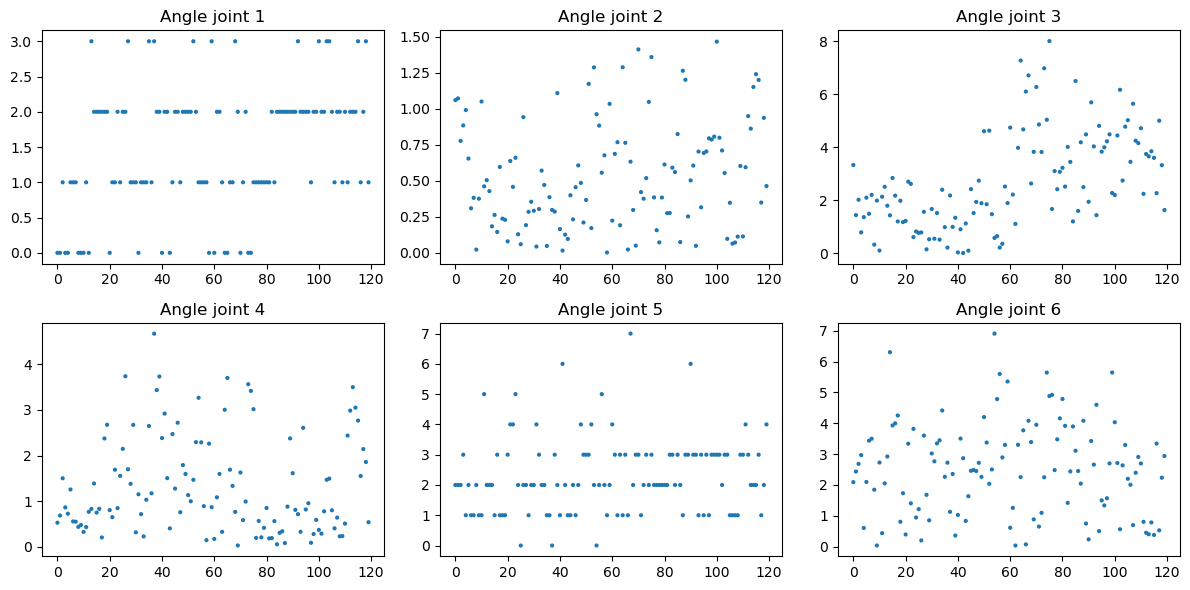

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
axes = axes.flatten()

for i in range(angles_error.shape[1]):
    ax = axes[i]
    angle_err = angles_error[:, i]
    ax.scatter(x=range(angle_err.shape[0]), y=angle_err, sizes=[4] * len(angle_err))
    title = "Angle joint {}".format(i + 1)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [7]:
angles_measure_noises = np.var(angles_error, axis=0)

In [9]:
np.var(angles_error, axis=0)

array([0.78222222, 0.13929596, 3.22626096, 1.10655453, 1.51      ,
       2.22502083])

In [10]:
np.std(angles_error, axis=0)

array([0.88443328, 0.37322374, 1.79617955, 1.05192896, 1.22882057,
       1.49165037])

In [13]:
def get_angle_initial_expectation_and_cov(home_position_file):
    home_position_data = pd.read_csv(home_position_csv_file)
    total_rows = len(home_position_data)

    # Calculate the starting and ending indices for the middle 50% data
    start_idx = total_rows // 4  # Start at 25% of the total rows
    end_idx = start_idx + total_rows // 2  # End at 75% of the total rows

    middle_data = home_position_data.iloc[start_idx:end_idx]
    gt_data = middle_data.iloc[:, 323:].values

    gt_data = gt_data.reshape(-1, 3, 48)
    gt_data = np.transpose(gt_data, (0, 2, 1))

    angles = []
    for i in range(gt_data.shape[0]):
        arm_hand_XYZ_wrt_shoulder, xyz_origin = convert_to_left_shoulder_coord(
            gt_data[i],
            arm_hand_fused_names)

        angles_at_current_frame, _, _ = calculate_six_arm_angles(arm_hand_XYZ_wrt_shoulder,
            xyz_origin,
            arm_hand_fused_names)
        angles_at_current_frame = np.array(angles_at_current_frame)
        angles.append(angles_at_current_frame)

    angles = np.array(angles)
    home_init_expectation = np.mean(angles, axis=0)
    home_init_cov = np.var(angles, axis=0)

    return home_init_expectation, home_init_cov

In [14]:
home_position_csv_file = measure_noise_csv_files[0]
home_init_expectation, home_init_cov = get_angle_initial_expectation_and_cov(home_position_csv_file)

In [17]:
home_init_expectation

array([ -0.56198347,  14.49521646, -21.06338939,   4.38744136,
       -13.94214876, -17.62511212])

For safe situation, set joint 3 expectation = -5

In [15]:
#home_init_expectation[2] = -5

In [16]:
angles_stats_dict = dict()

for i in range(6):
    stats = dict()

    angle_noise_var = angles_measure_noises[i]
    init_exp = home_init_expectation[i]
    init_cov = home_init_cov[i]

    stats["measure_noise"] = angle_noise_var
    stats["filter_state_estimate"] = init_exp
    stats["cov"] = init_cov

    angles_stats_dict["joint{}".format(i + 1)] = stats

In [12]:
des_json_file = "Hand_pose_estimation_3D/arm_and_hand/angles_stats.json"
with open(des_json_file, 'w') as file:
    json.dump(angles_stats_dict, file)